# Spin Ice logarithmic

In [2]:
###Imports###
%matplotlib notebook

import numpy as np
import mpmath as mp
mp.dps = 15; mp.pretty = True
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import random

In [3]:
N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
k_B = 1.38064852 * 10**-23 #Boltzmann constant

In [46]:
#####SINGLE MONOPOLE MODEL####

##function to compute physical values of single monopole spin ice system
#
def single_monopole(start_mu, start_T, num_T, T_max, tol, limit, switch, arbit_n):

    '''function to compute physical values of single monopole spin ice system
    Inputs:
    start_mu: the magnitude of the initial value of the chemical potential in kelvin
    start_T: the starting temperature in Kelvin
    T_step: iteration step of temperature
    T_max: the maximum temperature the function will run to
    tol: the convergence tolerance of the iterated chemical potentials
    limit: how many iterations on chemical potential the function will perform without achieving convergence
    switch: boolean, determines if for the first loop init_mu (False) is used
    or an arbitrary n value is used instead (True)
    arbit_n: an arbitrary value of n to be used for the first loop if enabled by the boolean
    '''
    
    ###constants###
    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    a = 4.34 * 10**-10 #lattice spacing of diamond lattice
    Q = 4.28 * 10**-13 #magnetic charge
    vol_per_site = ((10.1**3)/8) * 10**-30
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    T = start_T #Temperature in Kelvins (parameter)
    
    ##array initialisation##
    TempArray = np.geomspace(start_T, T_max, num=num_T)
    #TempArray = []
    SpecHeatArray = []
    nArray = []
    muSingleArray = []
    freeEnergyArray= []
    internalEnergyArray = []
    l_DArray = []
    
    j=0 #variable to cycle through elements of TempArray
    
    #while T <= T_max :
    while j < num_T :
        
        old_mu = 0
        new_mu = -start_mu * k_B
        init_mu = -start_mu * k_B
        beta = 1/(k_B * T)
        l_T = (mu_0 * Q * Q)/(k_B * T * 8 * np.pi) #Bjerrum length
        i=0 #iteration counter
        
        while np.abs((new_mu - old_mu)/new_mu) > tol and i < limit :
            
            if switch == True:
                n = arbit_n
                rho = n/vol_per_site
                #print("rho:", rho)
                l_D = np.sqrt((k_B * T)/(Q * Q * rho * mu_0)) #Debye length
                #print("l_D: ", l_D)
                #print("l_T:", l_T)
            
                deltaDH = k_B * T * ((l_T)/(l_D + a)) #Correction derived from Debye-Hueckel theory
                new_mu = init_mu + deltaDH #Corrected mu
                #print("deltaDH:",deltaDH)
                #print("mu:", new_mu)
                #print(old_mu)
                #print(np.abs(new_mu - old_mu))
                #print("")
                i += 1
                #switch = False

            else:
                #print("new mu:", new_mu)
                old_mu = new_mu #if new and old values not close enough, new replaces old
                #new number of monopoles
                n = (4/3 * np.exp(beta * old_mu))/(1 +(1/3 * ( 4 * np.exp(beta * old_mu))))
                #print("n:", n)
            
                #calculating new Debye length
                rho = n/vol_per_site
                #print("rho:", rho)
                l_D = np.sqrt((k_B * T)/(Q * Q * rho * mu_0)) #Deby length Calc
                #print("l_D: ", l_D)
                #print("l_T:", l_T)
                
                deltaDH = k_B * T * ((l_T)/(l_D + a))
                new_mu = init_mu + deltaDH
                #print("deltaDH:",deltaDH)
                #print("mu:", new_mu)
                #print(old_mu)
                #print(np.abs(new_mu - old_mu))
                #print("")
                i += 1
                if i==limit & limit != 1:
                    print('Warning: Monopole density did not converge after',limit, 'iterations!')
                    # This stops the function running forever if there is a problem with convergence.
        
        switch = False
        
        ##Calculates the differential of monopole density n wit respect to Temperature, used to calculate specific heat
        differential = mp.diff(lambda t:((4/3 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho * mu_0))) + a))) ))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho * mu_0))) + a)))))))), T)
        
        #differential = mp.diff(lambda t:((4/3 * mp.exp((1/(k_B * t)) * (init_mu + (k_B * t * ((l_T)/(l_D + a)))) ))/(1 +(1/3 * (4 * mp.exp((1/(k_B * t)) * (init_mu + (k_B * t * ((l_T)/(l_D + a)))) ))))), T)
        
        #differential = mp.diff(lambda t: eval(n), T)
        
        SpecHeatVal = - N_0 * (new_mu * float(differential))
        #print("differential of :", differential)
        #print("Specific Heat Value:", SpecHeatVal)
        
        #freeEnergy = (2 * new_mu * 2 * n) + ((Q*Q)/a)/(1 + a/l_D)
        fTerm3 = k_B*T*((n*np.log(n/2)) + ((1-n)*np.log(1-n)) + ((1-n)*np.log(2/3)))
        freeEnergy = -(new_mu + ((mu_0 * Q**2)/(4*np.pi*a)))*n + (l_D/a * deltaDH * n) + fTerm3
        
        #internalEnergyTerm = np.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        internalEnergyTerm = np.log(1+(a/np.sqrt((k_B*T)/(Q*Q*n/vol_per_site*mu_0)))) - (a/np.sqrt((k_B*T)/(Q * Q * n/vol_per_site * mu_0))) + 1/2*((a/np.sqrt((k_B * T)/(Q * Q * n/vol_per_site * mu_0)))**2)
        internalEnergy = - ((N_0 * k_B * T)/(6*np.pi*np.sqrt(3))) * internalEnergyTerm
        
        muSingleArray= np.append(muSingleArray, new_mu)
        #TempArray = np.append(TempArray, T)
        nArray = np.append(nArray,n)
        SpecHeatArray = np.append(SpecHeatArray, SpecHeatVal)
        freeEnergyArray = np.append(freeEnergyArray, freeEnergy)
        internalEnergyArray = np.append(internalEnergyArray, internalEnergy)
        l_DArray = np.append(l_DArray, l_D)
        #T += T_step
        
        j += 1
        if j < num_T :
            T = TempArray[j]
        #print("done")
    
    ##numerical calculation of entropy, omega##
    #DiffNumerical = np.gradient(nArray, T_step)
    DiffNumerical = np.gradient(nArray, TempArray)
    SpecHeatNumerical = - 1/2 * N_0 * (muSingleArray * DiffNumerical)

    DeltaS = cumtrapz((SpecHeatNumerical)/TempArray, TempArray)
    DeltaS = np.insert(DeltaS,0,0, axis=0) #inserts a 0 in 0th element to match other arrays' sizes
    EntropyTotalArray = DeltaS + (N_0*1/2 * k_B *np.log(3/2))

    Omega = internalEnergyArray - (init_mu * (N_0*nArray)) - (TempArray*EntropyTotalArray)
    print("")
    print("final")
    #print("Temperature values:", TempArray)
    #print("Specific Heat array:", SpecHeatArray)
    return (TempArray, SpecHeatArray, nArray, muSingleArray, freeEnergyArray, internalEnergyArray, l_DArray, SpecHeatNumerical, DeltaS, Omega, EntropyTotalArray)

In [42]:
def free_energy_single(mu, T, n_start, num_n, n_max, vacuum_entropy):
    
    #constants#
    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    a = 4.34 * 10**-10 #lattice spacing of diamond lattice
    Q = 4.28 * 10**-13 #magnetic charge
    vol_per_site = ((10.1**3)/8) * 10**-30
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    n = n_start
    
    #array initialisation#
    nArray = np.geomspace(n_start, n_max, num=num_n)
    OmegaArray = []
    
    #to turn on/off the vacuum entropy
    if vacuum_entropy == True:
        switch = 1
    else:
        switch = 0
    
    i = 0
    
    #while n <= n_max:
    while i < num_n:
        
        rho = n/vol_per_site
        l_D = np.sqrt((k_B * T)/(Q * Q * rho * mu_0)) #Debye length Calc
        
        internalEnergyTerm = np.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        #internalEnergyTerm = np.log(1+(a/np.sqrt((k_B*T)/(Q*Q*n/vol_per_site*mu_0)))) - (a/np.sqrt((k_B*T)/(Q * Q * n/vol_per_site * mu_0))) + 1/2*((a/np.sqrt((k_B * T)/(Q * Q * n/vol_per_site * mu_0)))**2)
        #internalEnergy = - ((N_0 * k_B * T)/(6*np.pi*np.sqrt(3))) * internalEnergyTerm #Total internal energy
        internalEnergy = - ((4 * T)/(6*np.pi*np.sqrt(3))) * internalEnergyTerm #per site internal energy in Kelvin
        
        #Entropy = -k_B*N_0*( (n*np.log(n/2)) + ((1-n)*np.log(1-n)) + ((1-n)*np.log(2/3)) ) #Total entropy
        Entropy = - ( (n*np.log(n/2)) + ((1-n)*np.log(1-n)) + (switch*(1-n)*np.log(2/3)) ) #entropy per site w/out k_B
        
        #Omega = internalEnergy - (-mu*k_B * (N_0*n)) - (T*Entropy) #total free energy
        Omega = internalEnergy - (-mu*n) - (T*Entropy) #free energy per site in Kelvin
        
        #nArray = np.append(nArray, n)
        OmegaArray = np.append(OmegaArray, Omega)
        
        i += 1
        #print(i)
        if i < num_n :
            n = nArray[i]
        
    return(nArray, OmegaArray)

In [87]:
###finding minimums of omega arrays###
def minimum_finder(nArray, omegaArray):
    minima_ypos = []
    minima_xpos = []
    i = 2
    
    while i < np.size(omegaArray):
        third = omegaArray[i-2]
        second = omegaArray[i-1]
        first = omegaArray[i]
        
        if (second < third) & (second < first):
            minima_ypos = np.append(minima_ypos, second)
            minima_xpos = np.append(minima_xpos, nArray[i-1])
        
        i+=1
    
    return(minima_xpos, minima_ypos)

In [82]:
###free energy functions###

##mu = -0.50##
nArray_TempStatic1, OmegaArray_TempStatic1 = free_energy_single(0.50, 0.1505, 10**-4, 1000, 10**0, True)

##mu = -0.75##
nArray_TempStatic9, OmegaArray_TempStatic9 = free_energy_single(0.75, 0.1505, 10**-4, 1000, 10**0, True)

##mu = -1.00##
nArray_TempStatic2, OmegaArray_TempStatic2 = free_energy_single(1.00, 0.1505, 10**-4, 1000, 10**0, True)

##mu = -1.15##
nArray_TempStatic3, OmegaArray_TempStatic3 = free_energy_single(1.15, 0.1505, 10**-4, 1000, 10**0, True)

##mu = -1.30##
nArray_TempStatic4, OmegaArray_TempStatic4 = free_energy_single(1.30, 0.1505, 10**-4, 1000, 10**0, True)

##mu = -1.57##
nArray_TempStatic5, OmegaArray_TempStatic5 = free_energy_single(1.57, 0.1505, 10**-4, 1000, 10**0, True)

##mu = -1.90##
nArray_TempStatic6, OmegaArray_TempStatic6 = free_energy_single(1.90, 0.1505, 10**-4, 1000, 10**0, True)

##mu = -2.50##
nArray_TempStatic7, OmegaArray_TempStatic7 = free_energy_single(2.50, 0.1505, 10**-4, 1000, 10**0, True)

##mu = -4.35##
nArray_TempStatic8, OmegaArray_TempStatic8 = free_energy_single(4.35, 0.1505, 10**-4, 1000, 10**0, True)


C:\Users\Omar3\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log
C:\Users\Omar3\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


In [49]:
###0.50 mu, small ###
TempArray1, SpecHeatArray1, nArray1, muSingleArray1, freeEnergyArray1, internalEnergyArray1, l_DArray1, SpecHeatNumerical1, DeltaS1, Omega1, EntropyTotalArray1 = single_monopole(0.50, 0.01, 1000, 2, 1e-4, 1000, False, 0.0000141839)

###0.75 mu, small ###
TempArray9, SpecHeatArray9, nArray9, muSingleArray9, freeEnergyArray9, internalEnergyArray9, l_DArray9, SpecHeatNumerical9, DeltaS9, Omega9, EntropyTotalArray9 = single_monopole(0.75, 0.01, 1000, 2, 1e-4, 1000, False, 0.0000141839)

###1.00 mu, small ###
TempArray2, SpecHeatArray2, nArray2, muSingleArray2, freeEnergyArray2, internalEnergyArray2, l_DArray2, SpecHeatNumerical2, DeltaS2, Omega2, EntropyTotalArray2 = single_monopole(1.00, 0.01, 1000, 2, 1e-4, 1000, False, 0.0000141839)

###1.15 mu, small ###
TempArray3, SpecHeatArray3, nArray3, muSingleArray3, freeEnergyArray3, internalEnergyArray3, l_DArray3, SpecHeatNumerical3, DeltaS3, Omega3, EntropyTotalArray3 = single_monopole(1.15, 0.01, 1000, 2, 1e-4, 1000, False, 0.0000141839)

###1.30 mu, small ###
TempArray4, SpecHeatArray4, nArray4, muSingleArray4, freeEnergyArray4, internalEnergyArray4, l_DArray4, SpecHeatNumerical4, DeltaS4, Omega4, EntropyTotalArray4 = single_monopole(1.30, 0.01, 1000, 2, 1e-4, 1000, False, 0.0000141839)

###1.570 mu, transition ###
TempArray5, SpecHeatArray5, nArray5, muSingleArray5, freeEnergyArray5, internalEnergyArray5, l_DArray5, SpecHeatNumerical5, DeltaS5, Omega5, EntropyTotalArray5 = single_monopole(1.57, 0.01, 1000, 2, 1e-4, 1000, False, 0.0000141839)

##1.90 mu post-transition###
TempArray6, SpecHeatArray6, nArray6, muSingleArray6, freeEnergyArray6, internalEnergyArray6, l_DArray6, SpecHeatNumerical6, DeltaS6, Omega6, EntropyTotalArray6 = single_monopole(1.90, 0.01, 1000, 2, 1e-4, 1000, False, 0.0000141839)

##2.50 mu post-transition###
TempArray7, SpecHeatArray7, nArray7, muSingleArray7, freeEnergyArray7, internalEnergyArray7, l_DArray7, SpecHeatNumerical7, DeltaS7, Omega7, EntropyTotalArray7 = single_monopole(2.50, 0.01, 1000, 2, 1e-4, 1000, False, 0.0000141839)

###4.35 mu, initial mu ###
TempArray8, SpecHeatArray8, nArray8, muSingleArray8, freeEnergyArray8, internalEnergyArray8, l_DArray8, SpecHeatNumerical8, DeltaS8, Omega8, EntropyTotalArray8 = single_monopole(4.35, 0.01, 1000, 2, 1e-4, 1000, False, 0.0000141839)


final

final

final

final

final

final

final

final

final


<IPython.core.display.Javascript object>


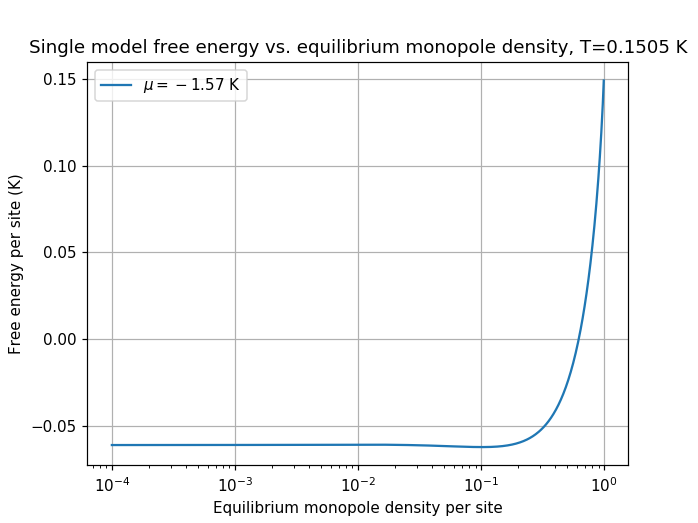

In [91]:
###free energy against equilibrium monopole density per site###
k_B = 1.38064852 * 10**-23 #Boltzmann constant

MonopoleDensityGraph1 = plt.figure()
plt.grid(True)

#plt.plot(nArray_TempStatic1, OmegaArray_TempStatic1, '-', label="$\mu=-0.50$ K")
#plt.plot(nArray_TempStatic9, OmegaArray_TempStatic9, '-', label="$\mu=-0.75$ K")
#plt.plot(nArray_TempStatic2, OmegaArray_TempStatic2, '-', label="$\mu=-1.00$ K")
#plt.plot(nArray_TempStatic3, OmegaArray_TempStatic3, '-', label="$\mu=-1.15$ K")
#plt.plot(nArray_TempStatic4, OmegaArray_TempStatic4, '-', label="$\mu=-1.30$ K")
plt.plot(nArray_TempStatic5, OmegaArray_TempStatic5, '-', label="$\mu=-1.57$ K")
#plt.plot(nArray_TempStatic6, OmegaArray_TempStatic6, '-', label="$\mu=-1.90$ K")
#plt.plot(nArray_TempStatic7, OmegaArray_TempStatic7, '-', label="$\mu=-2.50$ K")
#plt.plot(nArray_TempStatic8, OmegaArray_TempStatic8, '-', label="$\mu=-4.35$ K")

plt.xlabel("Equilibrium monopole density per site")
plt.xscale('log')

#plt.xlim(10**-3, 10**-0)
#plt.ylim(-0.0625,-0.05)

##0.7 mu minimum
#plt.xlim(0.9, 1)
#plt.ylim(-0.8, -0.6)

#1.570 mu T-0.1505 first minimum
#plt.ylim(-0.0611, -0.0609)
#plt.xlim(0.00004, 0.00025)

#1.570 mu T=0.1505 second minimum
#plt.xlim(0.03, 0.25)
#plt.ylim(-0.0625,-0.058)

plt.ylabel("Free energy per site (K)")
plt.title("Single model free energy vs. equilibrium monopole density, T=0.1505 K")
plt.legend(loc='upper left')
plt.savefig('Free energy against monopole density mu=1.570 T=0.1505 K.png')

In [90]:
###minima###
x_pos, y_pos = minimum_finder(nArray_TempStatic5, OmegaArray_TempStatic5)
print(x_pos)

[0.00015003 0.10069386]


<IPython.core.display.Javascript object>


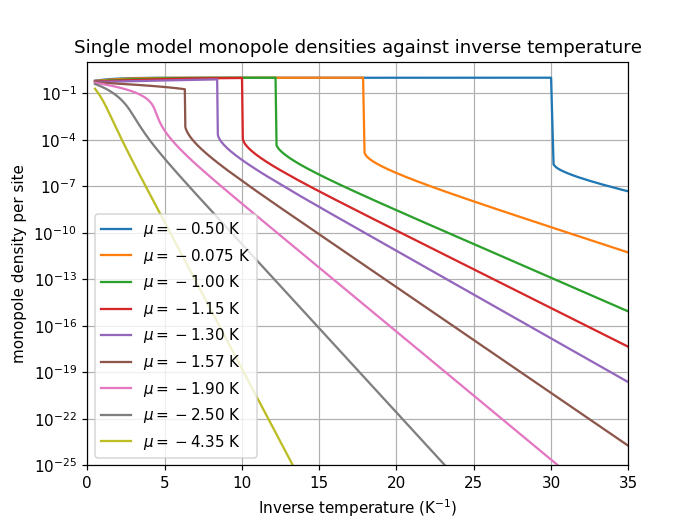

In [92]:
###monopole density against temperature###
graph1= plt.figure()
plt.grid(True)

N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
k_B = 1.38064852 * 10**-23 #Boltzmann constant

plt.plot(1/TempArray1, nArray1, '-', label="$\mu=-0.50$ K")
plt.plot(1/TempArray9, nArray9, '-', label="$\mu=-0.075$ K")
plt.plot(1/TempArray2, nArray2, '-', label="$\mu=-1.00$ K")
plt.plot(1/TempArray3, nArray3, '-', label="$\mu=-1.15$ K")
plt.plot(1/TempArray4, nArray4, '-', label="$\mu=-1.30$ K")
plt.plot(1/TempArray5, nArray5, '-', label="$\mu=-1.57$ K")
plt.plot(1/TempArray6, nArray6, '-', label="$\mu=-1.90$ K")
plt.plot(1/TempArray7, nArray7, '-', label="$\mu=-2.50$ K")
plt.plot(1/TempArray8, nArray8, '-', label="$\mu=-4.35$ K")

#plt.plot(TempArray2, nArray2, 'r-', label="$\mu=1.570$, $n_{large}$")
plt.xlabel("Inverse temperature (K$^{-1}$)")
plt.ylabel("monopole density per site")
plt.yscale('log')
#plt.xscale('log')
#plt.ylim(0.175,0.275)
plt.xlim(0,35)
plt.ylim(10**-25, 10)
plt.title("Single model monopole densities against inverse temperature")
plt.legend(loc='lower left')
plt.savefig('monopole densities against inverse temperature single model.png')

<IPython.core.display.Javascript object>


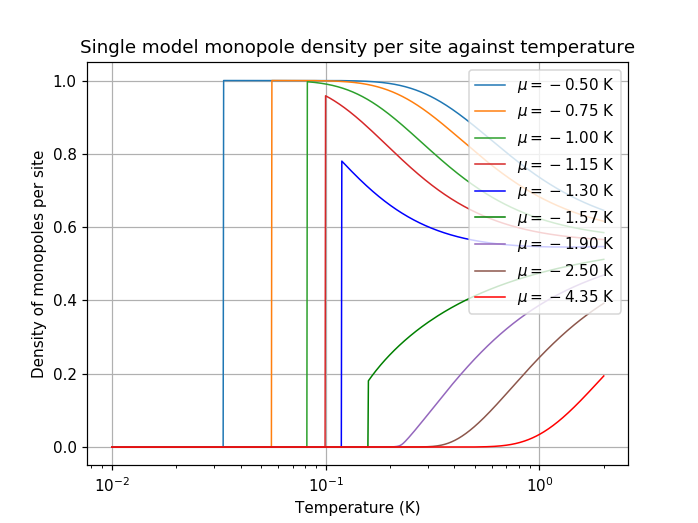

In [78]:
###n against temperature###
graph1= plt.figure()
plt.grid(True)
plt.plot(TempArray1, nArray1, '-', linewidth=1, label="$\mu=-0.50$ K")
plt.plot(TempArray9, nArray9, '-', linewidth=1, label="$\mu=-0.75$ K")
plt.plot(TempArray2, nArray2, '-', linewidth=1, label="$\mu=-1.00$ K")
plt.plot(TempArray3, nArray3, '-', linewidth=1, label="$\mu=-1.15$ K")
plt.plot(TempArray4, nArray4, 'b-', linewidth=1, label="$\mu=-1.30$ K")
plt.plot(TempArray5, nArray5, 'g-', linewidth=1, label="$\mu=-1.57$ K")
plt.plot(TempArray6, nArray6, '-', linewidth=1, label="$\mu=-1.90$ K")
plt.plot(TempArray7, nArray7, '-', linewidth=1, label="$\mu=-2.50$ K")
plt.plot(TempArray8, nArray8, 'r-', linewidth=1, label="$\mu=-4.35$ K")


plt.xlabel("Temperature (K)")
plt.ylabel("Density of monopoles per site")
plt.xscale('log')
#plt.xlim(0.1575,0.16)
#plt.ylim(0, 3)
plt.title("Single model monopole density per site against temperature")
plt.legend(loc='upper right')
#plt.savefig('Single model monopole density per site against temperature.png')

<IPython.core.display.Javascript object>


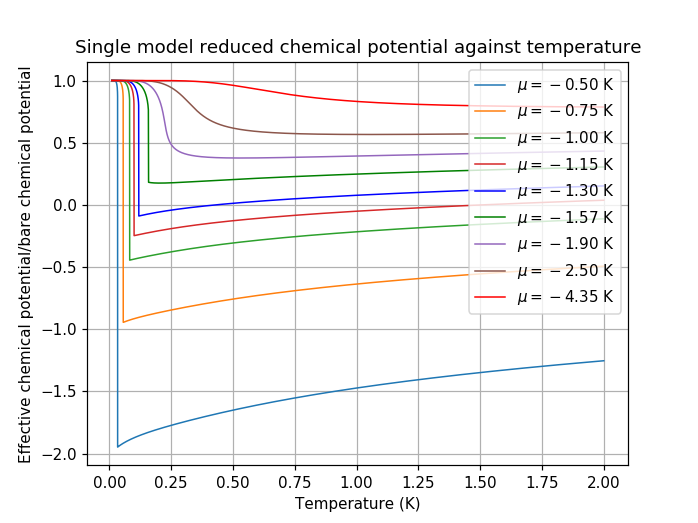

In [73]:
###reduced chemical potential against temperature###
graph1 = plt.figure()
plt.grid(True)

plt.plot(TempArray1, muSingleArray1/((k_B)*-0.50), '-', linewidth=1, label="$\mu=-0.50$ K")
plt.plot(TempArray9, muSingleArray9/((k_B)*-0.75), '-', linewidth=1, label="$\mu=-0.75$ K")
plt.plot(TempArray2, muSingleArray2/((k_B)*-1.00), '-', linewidth=1, label="$\mu=-1.00$ K")
plt.plot(TempArray3, muSingleArray3/((k_B)*-1.15), '-', linewidth=1, label="$\mu=-1.15$ K")
plt.plot(TempArray4, muSingleArray4/((k_B)*-1.30), 'b-', linewidth=1, label="$\mu=-1.30$ K")
plt.plot(TempArray5, muSingleArray5/((k_B)*-1.57), 'g-', linewidth=1, label="$\mu=-1.57$ K")
plt.plot(TempArray6, muSingleArray6/((k_B)*-1.90), '-', linewidth=1, label="$\mu=-1.90$ K")
plt.plot(TempArray7, muSingleArray7/((k_B)*-2.50), '-', linewidth=1, label="$\mu=-2.50$ K")
plt.plot(TempArray8, muSingleArray8/((k_B)*-4.35), 'r-', linewidth=1, label="$\mu=-4.35$ K")

plt.xlabel("Temperature (K)")
plt.ylabel("Effective chemical potential/bare chemical potential")
#plt.yscale('log')
#plt.xlim(0.1575,0.16)
#plt.ylim(0, 3)
plt.title("Single model reduced chemical potential against temperature")
plt.legend(loc='upper right')
plt.savefig("Reduced chemical potential against temperature single model.png")

<IPython.core.display.Javascript object>


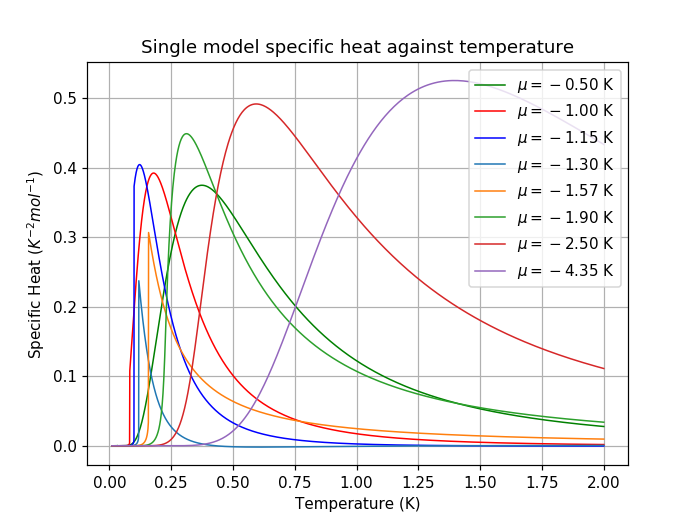

In [64]:
###Specific Heat against temperature###
graph1= plt.figure()
plt.grid(True)
plt.plot(TempArray1, SpecHeatArray1/(k_B*N_0), 'g-', linewidth=1, label="$\mu=-0.50$ K")
plt.plot(TempArray2, SpecHeatArray2/(k_B*N_0), 'r-', linewidth=1, label="$\mu=-1.00$ K")
plt.plot(TempArray3, SpecHeatArray3/(k_B*N_0), 'b-', linewidth=1, label="$\mu=-1.15$ K")
plt.plot(TempArray4, SpecHeatArray4/(k_B*N_0), '-', linewidth=1, label="$\mu=-1.30$ K")
plt.plot(TempArray5, SpecHeatArray5/(k_B*N_0), '-', linewidth=1, label="$\mu=-1.57$ K")
plt.plot(TempArray6, SpecHeatArray6/(k_B*N_0), '-', linewidth=1, label="$\mu=-1.90$ K")
plt.plot(TempArray7, SpecHeatArray7/(k_B*N_0), '-', linewidth=1, label="$\mu=-2.50$ K")
plt.plot(TempArray8, SpecHeatArray8/(k_B*N_0), '-', linewidth=1, label="$\mu=-4.35$ K")

plt.xlabel("Temperature (K)")
plt.ylabel("Specific Heat ($K^{-2} mol^{-1}$)")
#plt.yscale('log')
#plt.xlim(0.1575,0.16)
#plt.ylim(0, 3)
plt.title("Single model specific heat against temperature")
plt.legend(loc='upper right')
plt.savefig('SpecHeatAgainstTemperatureSingle1.png')

<IPython.core.display.Javascript object>


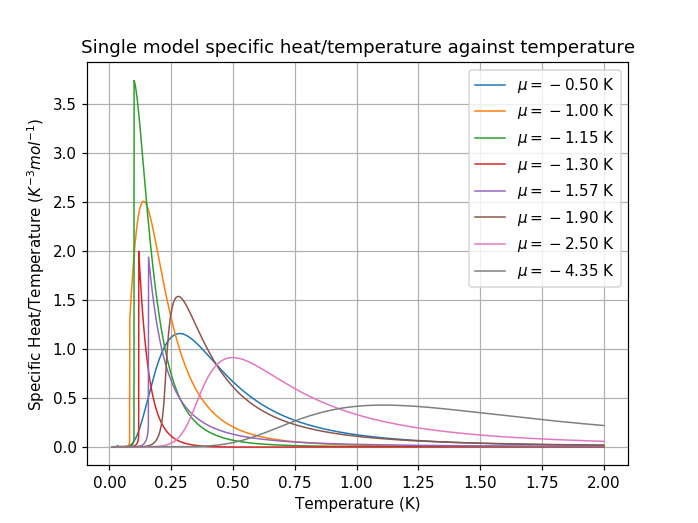

In [61]:
###Specific Heat/Temperature against temperature###
graph1= plt.figure()
plt.grid(True)
plt.plot(TempArray1, SpecHeatArray1/(k_B*N_0*TempArray1), '-', linewidth=1, label="$\mu=-0.50$ K")
plt.plot(TempArray2, SpecHeatArray2/(k_B*N_0*TempArray2), '-', linewidth=1, label="$\mu=-1.00$ K")
plt.plot(TempArray3, SpecHeatArray3/(k_B*N_0*TempArray3), '-', linewidth=1, label="$\mu=-1.15$ K")
plt.plot(TempArray4, SpecHeatArray4/(k_B*N_0*TempArray4), '-', linewidth=1, label="$\mu=-1.30$ K")
plt.plot(TempArray5, SpecHeatArray5/(k_B*N_0*TempArray5), '-', linewidth=1, label="$\mu=-1.57$ K")
plt.plot(TempArray6, SpecHeatArray6/(k_B*N_0*TempArray6), '-', linewidth=1, label="$\mu=-1.90$ K")
plt.plot(TempArray7, SpecHeatArray7/(k_B*N_0*TempArray7), '-', linewidth=1, label="$\mu=-2.50$ K")
plt.plot(TempArray8, SpecHeatArray8/(k_B*N_0*TempArray8), '-', linewidth=1, label="$\mu=-4.35$ K")

plt.xlabel("Temperature (K)")
plt.ylabel("Specific Heat/Temperature ($K^{-3} mol^{-1}$)")
#plt.yscale('log')
#plt.xlim(0.1575,0.16)
#plt.ylim(0, 3)
plt.title("Single model specific heat/temperature against temperature")
plt.legend(loc='upper right')
plt.savefig('SpecHeatOverTempAgainstTemperatureSingle1.png')

In [4]:
###Single + Double monopole model###
def double_monopole(start_mu, start_mu_2, start_T, num_T, T_max, tol, limit):

    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    a = 4.34 * 10**-10 #lattice spacing of diamond lattice
    Q = 4.28 * 10**-13 #magnetic charge
    vol_per_site = ((10.1**3)/8) * 10**-30
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    T = start_T #Temperature in Kelvins (parameter)
    
    ##array initialisation##
    #TempArray_double = []
    TempArray_double = np.geomspace(start_T, T_max, num=num_T)
    SpecHeatArray_double = []
    EntropyArray = []
    muDoubleArray = []
    mu2DoubleArray = []
    nArray = []
    n_2Array = []
    internalEnergyArray = []
    
    j=0 #variable to cycle through elements of TempArray
    
    #while T <= T_max :
    while j < num_T :
        
        i = 0
        old_mu = 0
        new_mu = -start_mu * k_B
        init_mu = -start_mu * k_B
        old_mu_2 = 0
        new_mu_2 = -start_mu_2 * k_B
        init_mu_2 = -start_mu_2 * k_B
        beta = 1/(k_B * T)
        l_T = (mu_0 * Q * Q)/(k_B * T * 8 * np.pi)
        #print("Temperature:", T)
        
        
        while np.abs((new_mu - old_mu)/new_mu) > tol and i < limit :
            #print("new mu:", new_mu)
            old_mu = new_mu #if new and old values not close enough, new replaces old
            old_mu_2 = new_mu_2
            #new number of monopoles
            n = (4/3 * np.exp(beta * old_mu))/(1 +(1/3 * ( 4 * np.exp(beta * old_mu) + np.exp(beta * old_mu_2))))
            n_2 = (1/3 * np.exp(beta * old_mu_2))/(1 +(1/3 * ( 4 * np.exp(beta * old_mu) + np.exp(beta * old_mu_2))))
            #print("n:", n)
            
            #calculating new Debye length
            rho = n/vol_per_site
            rho_2 = n_2/vol_per_site
            rho_I = rho + 4*rho_2
            #print("rho:", rho)
            l_D = np.sqrt((k_B * T)/(Q * Q * rho_I * mu_0)) #Debye length Calc
            #print("l_D: ", l_D)
            #print("l_T:", l_T)
            
            deltaDH = k_B * T * ((l_T)/(l_D + a))
            new_mu = init_mu + deltaDH
            new_mu_2 = init_mu_2 + 4*deltaDH
            #print("deltaDH:",deltaDH)
            #print("mu:", new_mu)
            #print("mu_2:", new_mu_2)
            #print(old_mu)
            #print(np.abs(new_mu - old_mu))
            #print("")
            
            i += 1
            if i==limit:
                print('Warning: Monopole density did not converge after', limit, 'iterations!')
                # This stops the function running forever if there is a problem with convergence.
        
        ##Calculates the differential of monopole density n wit respect to Temperature, used to calculate specific heat
        #differential = mp.diff(lambda t:((4/3 * mp.exp((1/(k_B * t)) * old_mu))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * old_mu) + mp.exp((1/(k_B * t)) * old_mu_2) )))), T)
        #differential_2 = mp.diff(lambda t:((1/3 * mp.exp((1/(k_B * t)) * old_mu_2))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * old_mu) + mp.exp((1/(k_B * t)) * old_mu_2) )))), T)
        
        differential = mp.diff(lambda t:((4/3 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a))) ))/(1 +(1/3 * ( (4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a))))) + mp.exp((1/(k_B * t)) * (init_mu_2 + 4 * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) ) ))), T)
        differential_2 = mp.diff(lambda t:((1/3 * mp.exp((1/(k_B * t)) * (init_mu_2 + 4 * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))))/(1 +(1/3 * ( 4 * mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) + mp.exp((1/(k_B * t)) * (init_mu_2 + 4 * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)))) )))), T)
        
        SpecHeatVal = - N_0 * (new_mu * float(differential) + new_mu_2 * float(differential_2))
        #print("differential of n wrt T:", differential)
        #print("differential of n_2 wrt T:", differential_2)
        #print("Specific Heat Value:", SpecHeatVal)
        
        Entropy = - k_B * N_0 *( (n*np.log(n/2) + (n_2*np.log(2*n_2) + ((1-n-n_2)*np.log(1-n-n_2)) + ((1-n-n_2)*np.log(2/3)) ) ) )
        #Entropy_corrected = Entropy - (8.314 * 1/2*np.log(3/2))
        
        internalEnergyTerm = np.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        #internalEnergyTerm = np.log(1+(a/np.sqrt((k_B*T)/(Q*Q*n/vol_per_site*mu_0)))) - (a/np.sqrt((k_B*T)/(Q * Q * n/vol_per_site * mu_0))) + 1/2*((a/np.sqrt((k_B * T)/(Q * Q * n/vol_per_site * mu_0)))**2)
        internalEnergy = - ((4 * N_0 * k_B * T)/(6*np.pi*np.sqrt(3))) * internalEnergyTerm
        
        nArray = np.append(nArray, n)
        n_2Array = np.append(n_2Array, n_2)
        muDoubleArray = np.append(muDoubleArray, new_mu)
        mu2DoubleArray = np.append(mu2DoubleArray, new_mu_2)
        EntropyArray = np.append(EntropyArray, Entropy)
        internalEnergyArray = np.append(internalEnergyArray, internalEnergy)
        #TempArray_double = np.append(TempArray_double, T)
        SpecHeatArray_double = np.append(SpecHeatArray_double, SpecHeatVal)
        
        #T += T_step
        
        j += 1
        if j < num_T :
            T = TempArray_double[j]
        #print("done")
        
    ##numerical calculation of entropy, omega##
    DiffNumerical = np.gradient(nArray, TempArray_double)
    DiffNumerical_2 = np.gradient(n_2Array, TempArray_double)
    SpecHeatNumerical = - 1/2 * N_0 * (muDoubleArray * DiffNumerical + mu2DoubleArray * DiffNumerical_2)

    DeltaS = cumtrapz((SpecHeatNumerical)/TempArray_double, TempArray_double)
    DeltaS = np.insert(DeltaS,0,0, axis=0) #inserts a 0 in 0th element to match other arrays' sizes
    EntropyTotalArray = DeltaS + (N_0*1/2 * k_B *np.log(3/2))

    Omega = internalEnergyArray - (init_mu * (N_0*nArray)) - (init_mu_2 * (N_0*n_2Array)) - (TempArray_double*EntropyTotalArray)
        
    print("")
    print("final")
    #print("Temperature values:", TempArray_double)
    #print("Specific Heat array:", SpecHeatArray_double)
    return (TempArray_double, SpecHeatArray_double, EntropyArray, muDoubleArray, mu2DoubleArray, nArray, n_2Array, SpecHeatNumerical, EntropyTotalArray, Omega)

In [36]:
def free_energy_double(mu_input, T, n_start, num_n, n_max, vacuum_entropy):
    
    #constants#
    mu_0 = 4 * np.pi * 10**-7 #vacuum permeability
    a = 4.34 * 10**-10 #lattice spacing of diamond lattice
    Q = 4.28 * 10**-13 #magnetic charge
    vol_per_site = ((10.1**3)/8) * 10**-30
    N_0 = 6.02214 * 10**23 #Total number of site, avagadro's number
    k_B = 1.38064852 * 10**-23 #Boltzmann constant
    n = n_start
    
    mu = -mu_input
    mu_2 = 4 * mu
    
    #array initialisation#
    nArray = np.geomspace(n_start, n_max, num=num_n)
    OmegaArray = []
    
    #to turn on/off the vacuum entropy
    if vacuum_entropy == True:
        switch = 1
    else:
        switch = 0
    
    i = 0
    
    #while n <= n_max:
    while i < num_n:
        
        rho = n/vol_per_site
        rho_2 = n_2/vol_per_site
        rho_I = rho + 4*rho_2
        l_D = np.sqrt((k_B * T)/(Q * Q * rho_I * mu_0)) #Debye length Calc
        
        internalEnergyTerm = np.log(1+(a/l_D)) - (a/l_D) + 1/2*((a/l_D)**2)
        #internalEnergyTerm = np.log(1+(a/np.sqrt((k_B*T)/(Q*Q*n/vol_per_site*mu_0)))) - (a/np.sqrt((k_B*T)/(Q * Q * n/vol_per_site * mu_0))) + 1/2*((a/np.sqrt((k_B * T)/(Q * Q * n/vol_per_site * mu_0)))**2)
        #internalEnergy = - ((N_0 * k_B * T)/(6*np.pi*np.sqrt(3))) * internalEnergyTerm #Total internal energy
        internalEnergy = - ((4 * T)/(6*np.pi*np.sqrt(3))) * internalEnergyTerm #per site internal energy in Kelvin
        
        #Entropy = -k_B*N_0*( (n*np.log(n/2)) + ((1-n)*np.log(1-n)) + ((1-n)*np.log(2/3)) ) #Total entropy
        Entropy = -( (n*np.log(n/2)) + (n_2*np.log(2*n_2)) + ((1-n-n_2)*np.log(1-n-n_2)) + (switch*(1-n-n_2)*np.log(2/3)) ) #entropy
        
        #Omega = internalEnergy - (-mu*k_B * (N_0*n)) - (T*Entropy) #total free energy
        Omega = internalEnergy - (mu*n) - (mu_2*n_2) - (T*Entropy) #free energy per site in Kelvin
        
        #nArray = np.append(nArray, n)
        OmegaArray = np.append(OmegaArray, Omega)
        
        i += 1
        if i < num_n :
            n = nArray[i]
        
    return(nArray, OmegaArray)

In [ ]:
### inspection of exponentials in n
#  exp_n  = mp.exp((1/(k_B * t)) * (init_mu + k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a)) ) )

#  exp_n2 = mp.exp((1/(k_B * t)) * (init_mu_2 + 4 * k_B * t * (((mu_0 * Q * Q)/(k_B * t * 8 * mp.pi))/((mp.sqrt((k_B * t)/(Q * Q * rho_I * mu_0))) + a))))

In [37]:
###
nArray_TempStatic_double5, OmegaArray_TempStatic_double5 = free_energy_double(1.570, 0.1505, 10**-8, 1000, 10**0, True)


NameError: name 'n_2' is not defined

In [ ]:
###free energy against equilibrium monopole density per site###
k_B = 1.38064852 * 10**-23 #Boltzmann constant

MonopoleDensityGraph1 = plt.figure()
plt.grid(True)
plt.plot(nArray_TempStatic5, OmegaArray_TempStatic5/(N_0 * k_B), 'b-', label="$\mu=1.570$")


plt.xlabel("monopole density per site")
plt.xscale('log')

#plt.xlim(10**-3, 10**-0)
#plt.ylim(-0.0625,-0.05)

##0.7 mu minimum
#plt.xlim(0.9, 1)
#plt.ylim(-0.8, -0.6)

#1.570 mu T-0.1505 first minimum
#plt.ylim(-0.0611, -0.0609)
#plt.xlim(0.00004, 0.00025)

#1.570 mu T=0.1505 second minimum
#plt.xlim(0.03, 0.25)
#plt.ylim(-0.0625,-0.058)

plt.ylabel("free energy per site (K)")
plt.title("w/ vacuum entropy and 4/6 factor second minimum, T=0.1505 K")
plt.legend(loc='upper left')
#plt.savefig('Omega against monopole density second minimum, mu=1.570 T=0.1505 K.png')

In [5]:
###0.50 mu_1 values, double monopole###
TempArray_double1, SpecHeatArray_double1, EntropyArray_double1, muDoubleArray1, mu2DoubleArray1, nArray_double1, n_2Array_double1, SpecHeatNumerical_double1, EntropyTotalArray_double1, Omega_double1 = double_monopole(0.50, 4*0.50, 0.01, 1000, 30, 1e-4, 1000)

###0.75 mu_1 values, double monopole###
TempArray_double9, SpecHeatArray_double9, EntropyArray_double9, muDoubleArray9, mu2DoubleArray9, nArray_double9, n_2Array_double9, SpecHeatNumerical_double9, EntropyTotalArray_double9, Omega_double9 = double_monopole(0.75, 4*0.75, 0.01, 1000, 30, 1e-4, 1000)

###1.00 mu_1 values, double monopole###
TempArray_double2, SpecHeatArray_double2, EntropyArray_double2, muDoubleArray2, mu2DoubleArray2, nArray_double2, n_2Array_double2, SpecHeatNumerical_double2, EntropyTotalArray_double2, Omega_double2 = double_monopole(1.00, 4*1.00, 0.01, 1000, 30, 1e-4, 1000)

###1.15 mu_1 values, double monopole###
TempArray_double3, SpecHeatArray_double3, EntropyArray_double3, muDoubleArray3, mu2DoubleArray3, nArray_double3, n_2Array_double3, SpecHeatNumerical_double3, EntropyTotalArray_double3, Omega_double3 = double_monopole(1.15, 4*1.15, 0.01, 1000, 30, 1e-4, 1000)

###1.30 mu_1 values, double monopole###
TempArray_double4, SpecHeatArray_double4, EntropyArray_double4, muDoubleArray4, mu2DoubleArray4, nArray_double4, n_2Array_double4, SpecHeatNumerical_double4, EntropyTotalArray_double4, Omega_double4 = double_monopole(1.30, 4*1.30, 0.01, 1000, 30, 1e-4, 1000)

###1.57 mu_1 values, double monopole###
TempArray_double5, SpecHeatArray_double5, EntropyArray_double5, muDoubleArray5, mu2DoubleArray5, nArray_double5, n_2Array_double5, SpecHeatNumerical_double5, EntropyTotalArray_double5, Omega_double5 = double_monopole(1.57, 4*1.57, 0.01, 1000, 30, 1e-4, 1000)

###1.90 mu_1 values, double monopole###
TempArray_double6, SpecHeatArray_double6, EntropyArray_double6, muDoubleArray6, mu2DoubleArray6, nArray_double6, n_2Array_double6, SpecHeatNumerical_double6, EntropyTotalArray_double6, Omega_double6 = double_monopole(1.90, 4*1.90, 0.01, 1000, 30, 1e-4, 1000)

###2.50 mu_1 values, double monopole###
TempArray_double7, SpecHeatArray_double7, EntropyArray_double7, muDoubleArray7, mu2DoubleArray7, nArray_double7, n_2Array_double7, SpecHeatNumerical_double7, EntropyTotalArray_double7, Omega_double7 = double_monopole(2.50, 4*2.50, 0.01, 1000, 30, 1e-4, 1000)

###4.35 mu_1 values, double monopole###
TempArray_double8, SpecHeatArray_double8, EntropyArray_double8, muDoubleArray8, mu2DoubleArray8, nArray_double8, n_2Array_double8, SpecHeatNumerical_double8, EntropyTotalArray_double8, Omega_double8 = double_monopole(4.35, 4*4.35, 0.01, 1000, 30, 1e-4, 1000)


C:\Users\Omar3\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log
C:\Users\Omar3\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Omar3\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in log



final

final

final

final

final

final

final

final

final


In [ ]:
###monopole density against temperature###
graph1= plt.figure()
plt.grid(True)
plt.plot(1/TempArray_double5, nArray_double5 + 4*n_2Array_double5, 'b-', label="$\mu=1.570$, $n+4n_2$")
plt.plot(1/TempArray_double5, nArray_double5, 'g-', label="$\mu=1.570$, $n$")
plt.plot(1/TempArray_double5, n_2Array_double5, 'r-', label="$\mu=1.570$, $n_2$")
plt.xlabel("1/Temperature ($K^{-1}$)")
plt.ylabel("monopole density per site")
plt.yscale('log')
#plt.ylim(0.175,0.275)
#plt.xlim(6, 6.6)
#plt.ylim(10**-4,1)
plt.xlim(0,10)
plt.ylim(10**-25, 10)
plt.title("Single vs. double monopole densities against inverse temperature")
plt.legend(loc='lower left')
plt.savefig('Single and double monopole densities against inverse temp.png')

<IPython.core.display.Javascript object>


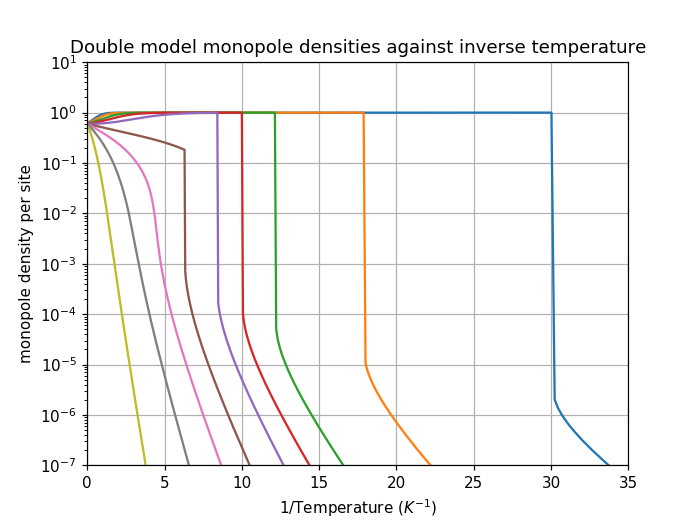

In [107]:
###monopole density against temperature###
graph1= plt.figure()
plt.grid(True)

plt.plot(1/TempArray_double1, nArray_double1 + n_2Array_double1, '-', label="$\mu=0.50$, $n+4n_2$")
plt.plot(1/TempArray_double9, nArray_double9 + n_2Array_double9, '-', label="$\mu=0.75$, $n+4n_2$")
plt.plot(1/TempArray_double2, nArray_double2 + n_2Array_double2, '-', label="$\mu=1.00$, $n+4n_2$")
plt.plot(1/TempArray_double3, nArray_double3 + n_2Array_double3, '-', label="$\mu=1.15$, $n+4n_2$")
plt.plot(1/TempArray_double4, nArray_double4 + n_2Array_double4, '-', label="$\mu=1.30$, $n+4n_2$")
plt.plot(1/TempArray_double5, nArray_double5 + n_2Array_double5, '-', label="$\mu=1.57$, $n+4n_2$")
plt.plot(1/TempArray_double6, nArray_double6 + n_2Array_double6, '-', label="$\mu=1.90$, $n+4n_2$")
plt.plot(1/TempArray_double7, nArray_double7 + n_2Array_double7, '-', label="$\mu=2.50$, $n+4n_2$")
plt.plot(1/TempArray_double8, nArray_double8 + n_2Array_double8, '-', label="$\mu=4.35$, $n+4n_2$")

plt.xlabel("1/Temperature ($K^{-1}$)")
plt.ylabel("monopole density per site")
plt.yscale('log')
#plt.ylim(0.175,0.275)
#plt.xlim(6, 6.6)
#plt.ylim(10**-4,1)
plt.xlim(0,35)
plt.ylim(10**-7, 10)
plt.title("Double model monopole densities against inverse temperature")
#plt.legend(loc='lower left')
plt.savefig('monopole densities against inverse temperature double model 4 factor lim.png')

<IPython.core.display.Javascript object>


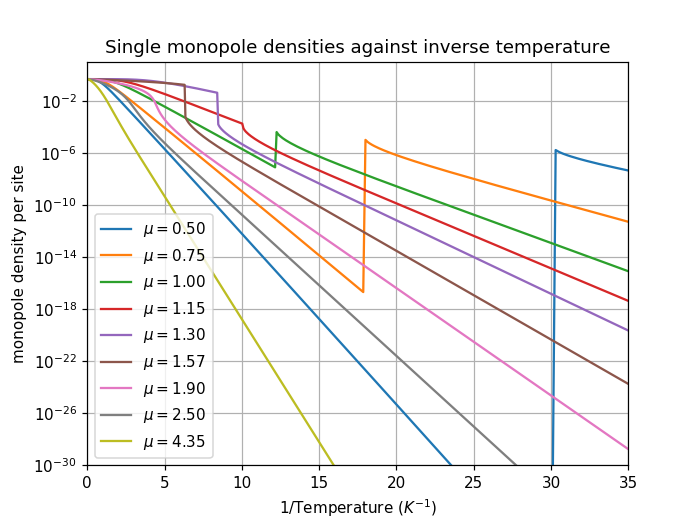

In [126]:
###monopole density against temperature###
graph1= plt.figure()
plt.grid(True)

plt.plot(1/TempArray_double1, nArray_double1 , '-', label="$\mu=0.50$")
plt.plot(1/TempArray_double9, nArray_double9 , '-', label="$\mu=0.75$")
plt.plot(1/TempArray_double2, nArray_double2 , '-', label="$\mu=1.00$")
plt.plot(1/TempArray_double3, nArray_double3 , '-', label="$\mu=1.15$")
plt.plot(1/TempArray_double4, nArray_double4 , '-', label="$\mu=1.30$")
plt.plot(1/TempArray_double5, nArray_double5 , '-', label="$\mu=1.57$")
plt.plot(1/TempArray_double6, nArray_double6 , '-', label="$\mu=1.90$")
plt.plot(1/TempArray_double7, nArray_double7 , '-', label="$\mu=2.50$")
plt.plot(1/TempArray_double8, nArray_double8 , '-', label="$\mu=4.35$")

plt.xlabel("1/Temperature ($K^{-1}$)")
plt.ylabel("monopole density per site")
plt.yscale('log')
#plt.ylim(0.175,0.275)
#plt.xlim(6, 6.6)
#plt.ylim(10**-4,1)
plt.xlim(0,35)
plt.ylim(10**-30, 10)
plt.title("Single monopole densities against inverse temperature")
plt.legend(loc='lower left')
plt.savefig('4 factor single monopole densities inverse temp.png')

<IPython.core.display.Javascript object>


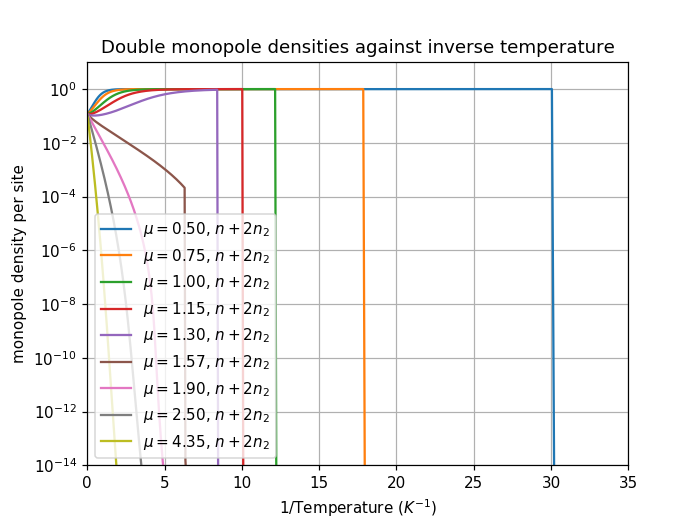

In [127]:
graph1= plt.figure()
plt.grid(True)

plt.plot(1/TempArray_double1, n_2Array_double1, '-', label="$\mu=0.50$, $n+2n_2$")
plt.plot(1/TempArray_double9, n_2Array_double9, '-', label="$\mu=0.75$, $n+2n_2$")
plt.plot(1/TempArray_double2, n_2Array_double2, '-', label="$\mu=1.00$, $n+2n_2$")
plt.plot(1/TempArray_double3, n_2Array_double3, '-', label="$\mu=1.15$, $n+2n_2$")
plt.plot(1/TempArray_double4, n_2Array_double4, '-', label="$\mu=1.30$, $n+2n_2$")
plt.plot(1/TempArray_double5, n_2Array_double5, '-', label="$\mu=1.57$, $n+2n_2$")
plt.plot(1/TempArray_double6, n_2Array_double6, '-', label="$\mu=1.90$, $n+2n_2$")
plt.plot(1/TempArray_double7, n_2Array_double7, '-', label="$\mu=2.50$, $n+2n_2$")
plt.plot(1/TempArray_double8, n_2Array_double8, '-', label="$\mu=4.35$, $n+2n_2$")

plt.xlabel("1/Temperature ($K^{-1}$)")
plt.ylabel("monopole density per site")
plt.yscale('log')
#plt.ylim(0.175,0.275)
#plt.xlim(6, 6.6)
#plt.ylim(10**-4,1)
plt.xlim(0,35)
plt.ylim(10**-14, 10)
plt.title("Double monopole densities against inverse temperature")
plt.legend(loc='lower left')
plt.savefig('4 factor double monopole densities inverse temp.png')

<IPython.core.display.Javascript object>


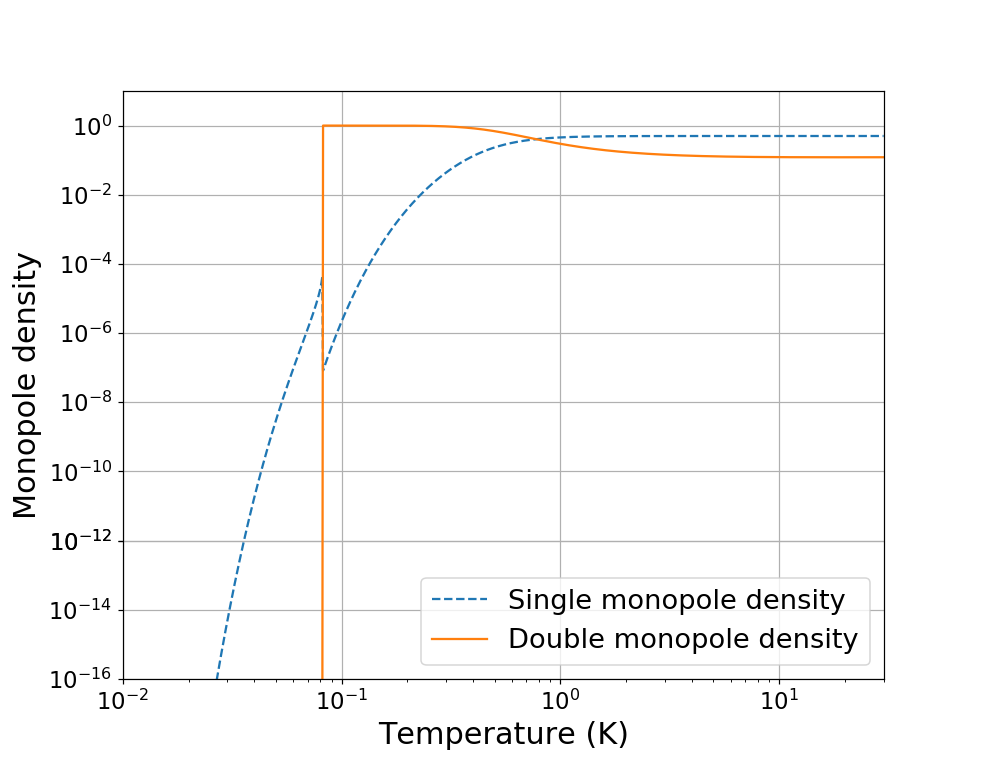

In [52]:
graph1= plt.figure(figsize=(9,7))
plt.grid(True)

plt.plot(TempArray_double2, nArray_double2 , '--', label="Single monopole density")
plt.plot(TempArray_double2, n_2Array_double2 , '-', label="Double monopole density")


plt.xlabel("Temperature (K)", size=20)
plt.ylabel("Monopole density", size=20)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(0.175,0.275)
#plt.xlim(6, 6.6)
#plt.ylim(10**-4,1)
plt.xlim(10**-2,30)
plt.ylim(10**-16, 10)
plt.yticks([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-12, 1e-14, 1e-16], fontsize=15)
plt.xticks(fontsize=15)
#plt.title("Double monopole densities against temperature")
plt.legend(loc='lower right', fontsize=18)
plt.savefig('Abstract monopole comparison figure3.png')

In [55]:
print(np.argmax(n_2Array_double2))
print(TempArray_double2[np.argmax(n_2Array_double2)])

263
0.0822997068525129


<IPython.core.display.Javascript object>


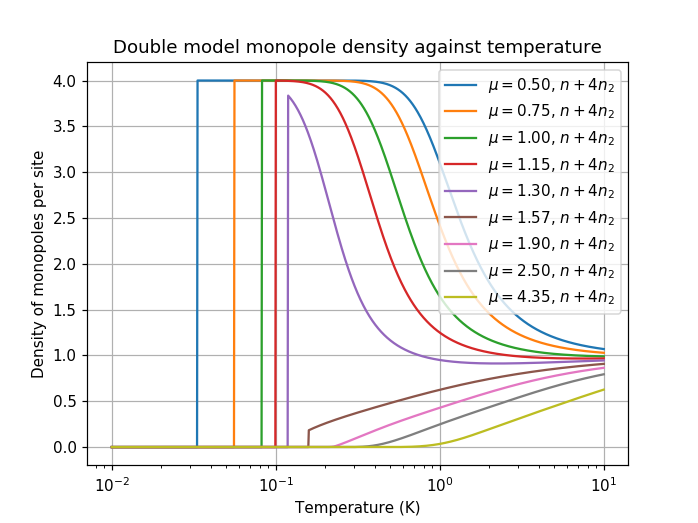

In [79]:
###n against temperature###
graph1= plt.figure()
plt.grid(True)
plt.plot(TempArray_double1, nArray_double1 + 4*n_2Array_double1, '-', label="$\mu=0.50$, $n+4n_2$")
plt.plot(TempArray_double9, nArray_double9 + 4*n_2Array_double9, '-', label="$\mu=0.75$, $n+4n_2$")
plt.plot(TempArray_double2, nArray_double2 + 4*n_2Array_double2, '-', label="$\mu=1.00$, $n+4n_2$")
plt.plot(TempArray_double3, nArray_double3 + 4*n_2Array_double3, '-', label="$\mu=1.15$, $n+4n_2$")
plt.plot(TempArray_double4, nArray_double4 + 4*n_2Array_double4, '-', label="$\mu=1.30$, $n+4n_2$")
plt.plot(TempArray_double5, nArray_double5 + 4*n_2Array_double5, '-', label="$\mu=1.57$, $n+4n_2$")
plt.plot(TempArray_double6, nArray_double6 + 4*n_2Array_double6, '-', label="$\mu=1.90$, $n+4n_2$")
plt.plot(TempArray_double7, nArray_double7 + 4*n_2Array_double7, '-', label="$\mu=2.50$, $n+4n_2$")
plt.plot(TempArray_double8, nArray_double8 + 4*n_2Array_double8, '-', label="$\mu=4.35$, $n+4n_2$")


plt.xlabel("Temperature (K)")
plt.ylabel("Density of monopoles per site")
plt.xscale('log')
#plt.xlim(0.1575,0.16)
#plt.ylim(0, 3)
plt.title("Double model monopole density against temperature")
plt.legend(loc='upper right')
plt.savefig('Double model monopole density against temperature.png')

<IPython.core.display.Javascript object>


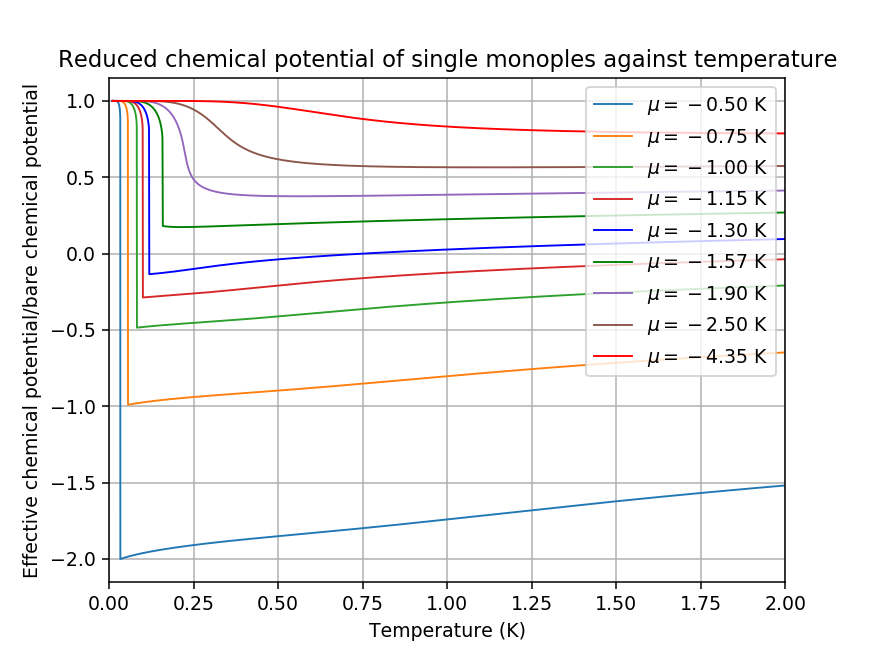

In [96]:
###corrected chemical potential aginst temperature single monopoles###
graph1 = plt.figure()
plt.grid(True)


plt.plot(TempArray_double1, muDoubleArray1/((k_B)*-0.50), '-', linewidth=1, label="$\mu=-0.50$ K")
plt.plot(TempArray_double9, muDoubleArray9/((k_B)*-0.75), '-', linewidth=1, label="$\mu=-0.75$ K")
plt.plot(TempArray_double2, muDoubleArray2/((k_B)*-1.00), '-', linewidth=1, label="$\mu=-1.00$ K")
plt.plot(TempArray_double3, muDoubleArray3/((k_B)*-1.15), '-', linewidth=1, label="$\mu=-1.15$ K")
plt.plot(TempArray_double4, muDoubleArray4/((k_B)*-1.30), 'b-', linewidth=1, label="$\mu=-1.30$ K")
plt.plot(TempArray_double5, muDoubleArray5/((k_B)*-1.57), 'g-', linewidth=1, label="$\mu=-1.57$ K")
plt.plot(TempArray_double6, muDoubleArray6/((k_B)*-1.90), '-', linewidth=1, label="$\mu=-1.90$ K")
plt.plot(TempArray_double7, muDoubleArray7/((k_B)*-2.50), '-', linewidth=1, label="$\mu=-2.50$ K")
plt.plot(TempArray_double8, muDoubleArray8/((k_B)*-4.35), 'r-', linewidth=1, label="$\mu=-4.35$ K")

plt.xlabel("Temperature (K)")
plt.ylabel("Effective chemical potential/bare chemical potential")
#plt.yscale('log')
plt.xlim(0,2.0)
#plt.ylim(0, 0.6)
plt.title("Reduced chemical potential of single monoples against temperature")
plt.legend(loc='upper right')
plt.savefig("Reduced chemical potential for single monopoles against temperature.png")

<IPython.core.display.Javascript object>


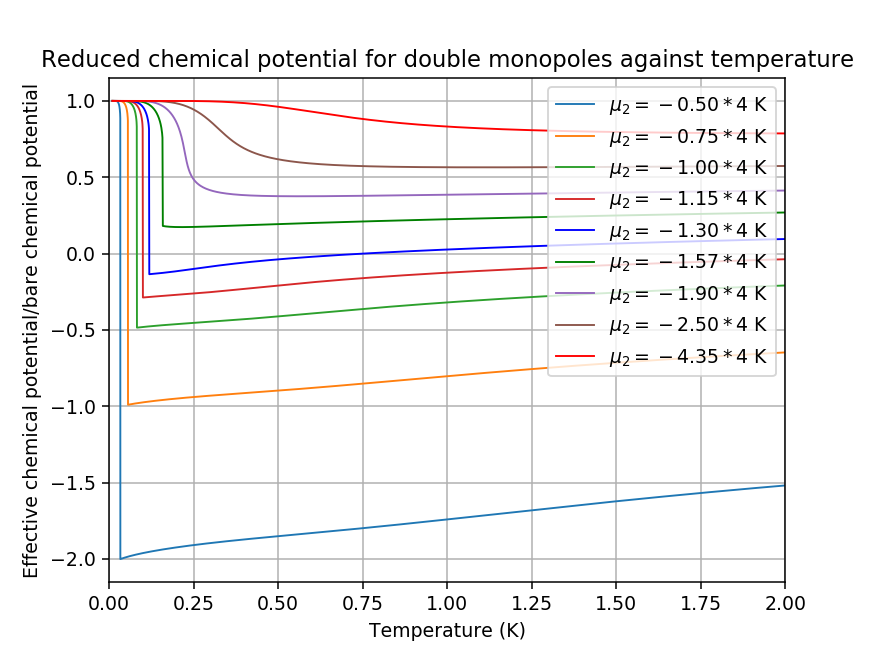

In [97]:
###corrected chemical potential aginst temperature single monopoles###
graph1 = plt.figure()
plt.grid(True)

plt.plot(TempArray_double1, mu2DoubleArray1/((k_B)*4*-0.50), '-', linewidth=1, label="$\mu_2=-0.50*4$ K")
plt.plot(TempArray_double9, mu2DoubleArray9/((k_B)*4*-0.75), '-', linewidth=1, label="$\mu_2=-0.75*4$ K")
plt.plot(TempArray_double2, mu2DoubleArray2/((k_B)*4*-1.00), '-', linewidth=1, label="$\mu_2=-1.00*4$ K")
plt.plot(TempArray_double3, mu2DoubleArray3/((k_B)*4*-1.15), '-', linewidth=1, label="$\mu_2=-1.15*4$ K")
plt.plot(TempArray_double4, mu2DoubleArray4/((k_B)*4*-1.30), 'b-', linewidth=1, label="$\mu_2=-1.30*4$ K")
plt.plot(TempArray_double5, mu2DoubleArray5/((k_B)*4*-1.57), 'g-', linewidth=1, label="$\mu_2=-1.57*4$ K")
plt.plot(TempArray_double6, mu2DoubleArray6/((k_B)*4*-1.90), '-', linewidth=1, label="$\mu_2=-1.90*4$ K")
plt.plot(TempArray_double7, mu2DoubleArray7/((k_B)*4*-2.50), '-', linewidth=1, label="$\mu_2=-2.50*4$ K")
plt.plot(TempArray_double8, mu2DoubleArray8/((k_B)*4*-4.35), 'r-', linewidth=1, label="$\mu_2=-4.35*4$ K")

plt.xlabel("Temperature (K)")
plt.ylabel("Effective chemical potential/bare chemical potential")
#plt.yscale('log')
plt.xlim(0,2)
#plt.ylim(0, 3)
plt.title("Reduced chemical potential for double monopoles against temperature")
plt.legend(loc='upper right')
plt.savefig("Reduced chemical potential for double monopoles against temperature.png")

In [ ]:
###Specific Heat aginst temperature###
graph1= plt.figure()
plt.grid(True)
plt.plot(TempArray_double1, SpecHeatArray_double1/(k_B*N_0), 'g-', linewidth=1, label="$\mu=-0.50$ K")
plt.plot(TempArray_double2, SpecHeatArray_double2/(k_B*N_0), 'r-', linewidth=1, label="$\mu=-1.00$ K")
plt.plot(TempArray_double3, SpecHeatArray_double3/(k_B*N_0), 'b-', linewidth=1, label="$\mu=-1.15$ K")
plt.plot(TempArray_double4, SpecHeatArray_double4/(k_B*N_0), '-', linewidth=1, label="$\mu=-1.30$ K")
plt.plot(TempArray_double5, SpecHeatArray_double5/(k_B*N_0), '-', linewidth=1, label="$\mu=-1.57$ K")
plt.plot(TempArray_double6, SpecHeatArray_double6/(k_B*N_0), '-', linewidth=1, label="$\mu=-1.90$ K")
plt.plot(TempArray_double7, SpecHeatArray_double7/(k_B*N_0), '-', linewidth=1, label="$\mu=-2.50$ K")
plt.plot(TempArray_double8, SpecHeatArray_double8/(k_B*N_0), '-', linewidth=1, label="$\mu=-4.35$ K")

plt.xlabel("Temperature (K)")
plt.ylabel("Specific Heat ($K^{-2} mol^{-1}$)")
#plt.yscale('log')
#plt.xlim(0,3)
plt.xlim(0, 4)
plt.title("Double monopole model specific heat against temperature")
plt.legend(loc='upper right')
#plt.savefig('SpecHeatAgainstTemperatureDouble1.png')

In [ ]:
###Specific Heat/Temperature against temperature###
graph1= plt.figure()
plt.grid(True)
plt.plot(TempArray_double1, SpecHeatArray_double1/(k_B*N_0*TempArray_double1), '-', linewidth=1, label="$\mu=-0.50$ K")
plt.plot(TempArray_double2, SpecHeatArray_double2/(k_B*N_0*TempArray_double2), '-', linewidth=1, label="$\mu=-1.00$ K")
plt.plot(TempArray_double3, SpecHeatArray_double3/(k_B*N_0*TempArray_double3), '-', linewidth=1, label="$\mu=-1.15$ K")
plt.plot(TempArray_double4, SpecHeatArray_double4/(k_B*N_0*TempArray_double4), '-', linewidth=1, label="$\mu=-1.30$ K")
plt.plot(TempArray_double5, SpecHeatArray_double5/(k_B*N_0*TempArray_double5), '-', linewidth=1, label="$\mu=-1.57$ K")
plt.plot(TempArray_double6, SpecHeatArray_double6/(k_B*N_0*TempArray_double6), '-', linewidth=1, label="$\mu=-1.90$ K")
plt.plot(TempArray_double7, SpecHeatArray_double7/(k_B*N_0*TempArray_double7), '-', linewidth=1, label="$\mu=-2.50$ K")
plt.plot(TempArray_double8, SpecHeatArray_double8/(k_B*N_0*TempArray_double8), '-', linewidth=1, label="$\mu=-4.35$ K")

plt.xlabel("Temperature (K)")
plt.ylabel("Specific Heat/Temperature ($K^{-3} mol^{-1}$)")
#plt.yscale('log')
#plt.xlim(0.1575,0.16)
plt.xlim(0, 2)
plt.title("Double monopole model specific heat/temperature against temperature")
plt.legend(loc='upper right')
#plt.savefig('SpecHeatOverTempAgainstTemperatureDouble1.png')